In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 4.1 MB/s eta 0:00:00


In [ ]:
#importar librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Cargar y preprocesar los datos
data = pd.read_csv('stroke_dataset.csv')
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [ ]:

data = data.dropna()

In [ ]:
le = LabelEncoder()
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_columns:
    data[col] = le.fit_transform(data[col])

In [ ]:
# Ingeniería de características
data['bmi_category'] = pd.cut(data['bmi'], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3])
data['age_group'] = pd.cut(data['age'], bins=[0, 18, 30, 45, 60, 100], labels=[0, 1, 2, 3, 4])
data['glucose_category'] = pd.cut(data['avg_glucose_level'], bins=[0, 70, 100, 125, 200, 300], labels=[0, 1, 2, 3, 4])



In [ ]:
X = data.drop('stroke', axis=1)
y = data['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

scaler = StandardScaler()
numeric_columns = ['age', 'avg_glucose_level', 'bmi']
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])


In [ ]:
# Función para entrenar y evaluar el modelo
def train_and_evaluate(X_train, y_train, X_test, y_test, class_weight=None):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'num_leaves': [31, 63, 127]
    }

    # Realizar búsqueda de hiperparámetros
    grid_search = GridSearchCV(LGBMClassifier(random_state=42, class_weight=class_weight),
                               param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Mejor combinación de hiperparámetros:", grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Devolver resultados y el mejor modelo
    return best_model, y_pred, y_pred_proba

# Llamar a la función y almacenar los resultados
best_model, y_pred, y_pred_proba = train_and_evaluate(X_train, y_train, X_test, y_test)

# Imprimir métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Ahora best_model está definido aquí
print("Mejor modelo:", best_model)


[LightGBM] [Info] Number of positive: 194, number of negative: 3790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 3984, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048695 -> initscore=-2.972263
[LightGBM] [Info] Start training from score -2.972263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Enfoque 1: SMOTE + Ajuste de umbral
print("Enfoque 1: SMOTE + Ajuste de umbral")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


model_smote, y_pred_smote, y_pred_proba_smote = train_and_evaluate(X_train_smote, y_train_smote, X_test, y_test)


Enfoque 1: SMOTE + Ajuste de umbral
[LightGBM] [Info] Number of positive: 3790, number of negative: 3790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 800
[LightGBM] [Info] Number of data points in the train set: 7580, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [ ]:
# Ajustar el umbral de decisión
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_smote)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_adjusted = (y_pred_proba_smote >= best_threshold).astype(int)

print("\nResultados con umbral ajustado:")
print("Mejor umbral:", best_threshold)
print("Classification Report:")
print(classification_report(y_test, y_pred_adjusted))



Resultados con umbral ajustado:
Mejor umbral: 0.9496103188121606
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       943
           1       0.00      0.00      0.00        54

    accuracy                           0.94       997
   macro avg       0.47      0.50      0.48       997
weighted avg       0.89      0.94      0.92       997



<ipython-input-29-075d056fd148>:3: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
# Enfoque 2: Pesos de clase
print("\nEnfoque 2: Pesos de clase")
class_weights = {0: 1, 1: 10}  # Damos más peso a la clase minoritaria
model_weighted, y_pred_weighted, y_pred_proba_weighted = train_and_evaluate(X_train, y_train, X_test, y_test, class_weight=class_weights)


Enfoque 2: Pesos de clase
[LightGBM] [Info] Number of positive: 194, number of negative: 3790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 3984, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338569 -> initscore=-0.669678
[LightGBM] [Info] Start training from score -0.669678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

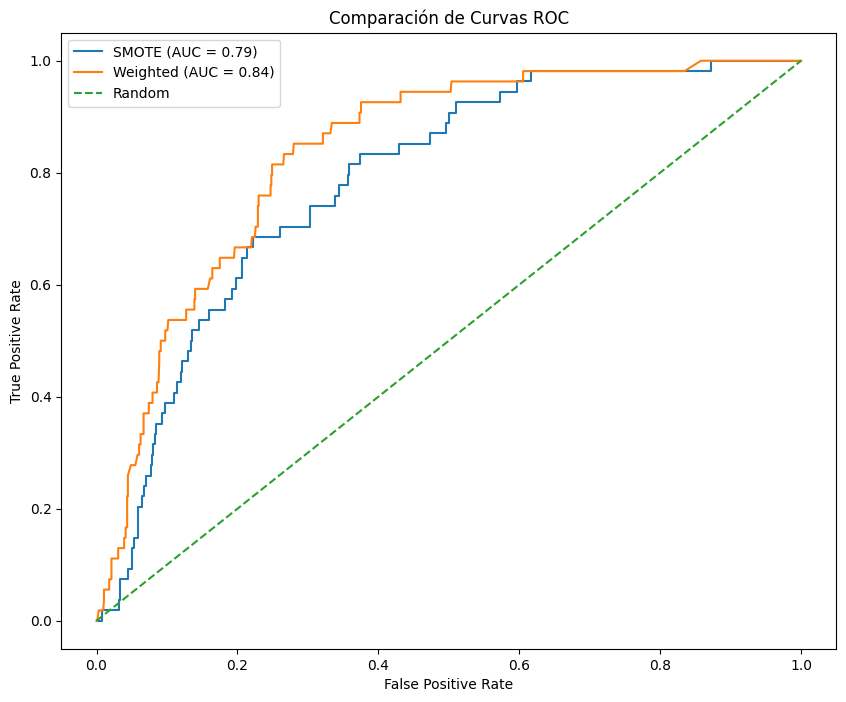

In [ ]:

# Comparación de curvas ROC
plt.figure(figsize=(10, 8))
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)
fpr_weighted, tpr_weighted, _ = roc_curve(y_test, y_pred_proba_weighted)

plt.plot(fpr_smote, tpr_smote, label=f'SMOTE (AUC = {roc_auc_score(y_test, y_pred_proba_smote):.2f})')
plt.plot(fpr_weighted, tpr_weighted, label=f'Weighted (AUC = {roc_auc_score(y_test, y_pred_proba_weighted):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparación de Curvas ROC')
plt.legend()
plt.show()


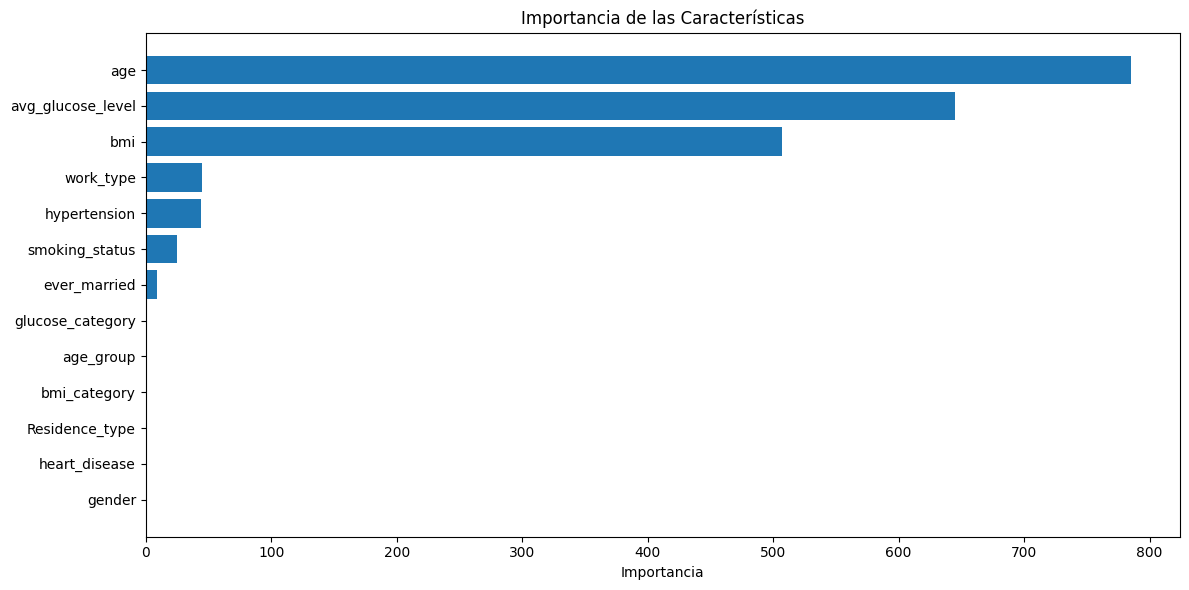

In [ ]:


# Importancia de las características (usando el modelo con mejor rendimiento)
best_model = model_smote if roc_auc_score(y_test, y_pred_proba_smote) > roc_auc_score(y_test, y_pred_proba_weighted) else model_weighted
feature_importance = best_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()